In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import json 
import random 
from warnings import filterwarnings
filterwarnings('ignore')
import math
from datetime import datetime


In [19]:
config = json.loads(open('config.json').read()) 
train_set_path = config["local"]["train_set_path"]
test_set_path = config["local"]["test_set_path"]
val_set_path = config["local"]["val_set_path"]
model_path = config["local"]["model_path"]
train= False
save_model = False
max_epochs = 200
early_stopping = True

In [20]:
# Data Augmentation and Rescaling for Training and Validation Sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)  # Just rescaling for validation data

# Create Training Set Generator
train_set = train_datagen.flow_from_directory(
    train_set_path,        # Path to the folder containing training images
    target_size=(150, 150),          # Resize images to 150x150
    batch_size=32,                   # Process 32 images per batch
    class_mode='binary'              # Binary classification (cats vs dogs)
)

#Validation Set
val_set = val_datagen.flow_from_directory(val_set_path,
                                           target_size=(150,150),
                                           batch_size = 32,
                                           class_mode='binary',
                                           shuffle=False)


# Define the CNN Model
classifier = Sequential([
    Conv2D(32, (3, 3), input_shape=(150, 150, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [21]:
# Compile the Model
classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

if train: 
    if early_stopping:
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    else:
        early_stopping = None

    # Train the Model
    history = classifier.fit(
        train_set,
        steps_per_epoch=math.ceil(train_set.samples / train_set.batch_size),
        epochs=max_epochs,
        validation_data=val_set,
        validation_steps=math.ceil(val_set.samples / val_set.batch_size),
        callbacks=[early_stopping]
    )
    
    if not os.path.exists(os.path.dirname(model_path)):
        os.makedirs(os.path.dirname(model_path))    
    if save_model:
        classifier.save(model_path)
else: 
    classifier = tf.keras.models.load_model(model_path)




Epoch 1/200
625/625 [==============================] - 303s 484ms/step - loss: 0.6582 - accuracy: 0.5974 - val_loss: 0.6451 - val_accuracy: 0.6488
Epoch 2/200
625/625 [==============================] - 306s 490ms/step - loss: 0.5360 - accuracy: 0.7283 - val_loss: 0.4570 - val_accuracy: 0.7892
Epoch 3/200
625/625 [==============================] - 294s 470ms/step - loss: 0.4451 - accuracy: 0.7933 - val_loss: 0.4339 - val_accuracy: 0.8012
Epoch 4/200
625/625 [==============================] - 319s 510ms/step - loss: 0.3992 - accuracy: 0.8207 - val_loss: 0.3797 - val_accuracy: 0.8300
Epoch 5/200
625/625 [==============================] - 282s 451ms/step - loss: 0.3765 - accuracy: 0.8314 - val_loss: 0.3691 - val_accuracy: 0.8364
Epoch 6/200
625/625 [==============================] - 291s 465ms/step - loss: 0.3448 - accuracy: 0.8471 - val_loss: 0.3537 - val_accuracy: 0.8492
Epoch 7/200
625/625 [==============================] - 292s 468ms/step - loss: 0.3237 - accuracy: 0.8600 - val_loss: 0

### Prediction of Single Image

1/1 [==============================] - 0s 298ms/step


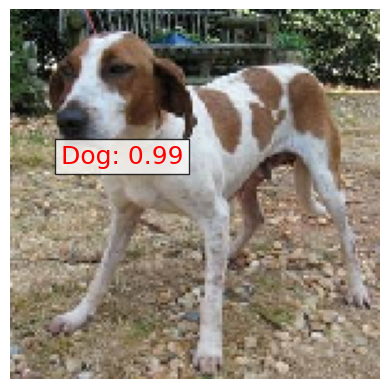

In [22]:
#get random image from train_set_folder
all_files = []
for root, dirs, files in os.walk(train_set_path):
    for file in files:
        all_files.append(os.path.join(root, file))  
img_path = random.choice(all_files)
img1 = image.load_img(img_path, target_size=(150, 150))  # Match target size with training size
img = image.img_to_array(img1)  # Convert image to array
img = img / 255.0  # Normalize the image

# Create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)

# Make prediction
prediction = classifier.predict(img)  # No need for batch_size or steps arguments

# Interpret the prediction
if prediction[0, 0] > 0.5:
    value = 'Dog: %1.2f' % prediction[0, 0]
    plt.text(20, 62, value, color='red', fontsize=18, bbox=dict(facecolor='white', alpha=0.8))
else:
    value = 'Cat: %1.2f' % (1.0 - prediction[0, 0])
    plt.text(20, 62, value, color='red', fontsize=18, bbox=dict(facecolor='white', alpha=0.8))

# Display the image
plt.imshow(img1)
plt.axis('off')  # Hide axes
plt.show()


In [23]:
# Reset the generator before prediction
val_set.reset()
steps = math.ceil(val_set.samples / val_set.batch_size)
# Use predict with steps argument
predictions = classifier.predict(val_set, steps=steps)
df = pd.DataFrame({
    'filename': val_set.filenames,
    'predict': predictions.flatten(),
    'y': val_set.classes
})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
df['y_pred'] = df['predict']>0.5
df.y_pred = df.y_pred.astype(int)
df.head(10)

157/157 [==============================] - 31s 197ms/step


,filename,predict,y,y_pred
0,cat/cat.100.jpg,0.54722,0,1
1,cat/cat.1000.jpg,0.03508,0,0
2,cat/cat.10000.jpg,0.62415,0,1
3,cat/cat.10010.jpg,0.42797,0,0
4,cat/cat.10017.jpg,0.20459,0,0
5,cat/cat.10022.jpg,0.70653,0,1
6,cat/cat.10024.jpg,0.12985,0,0
7,cat/cat.10031.jpg,0.23148,0,0
8,cat/cat.10040.jpg,0.00003,0,0
9,cat/cat.10051.jpg,0.79105,0,1


In [24]:
misclassified = df[df['y']!=df['y_pred']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 645


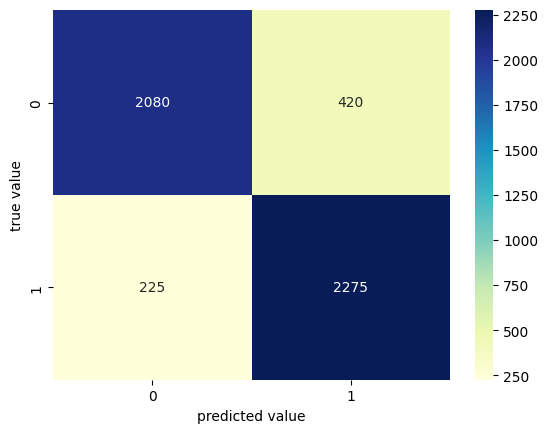

In [25]:
conf_matrix = confusion_matrix(df.y,df.y_pred)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

In [26]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 128)      

### Model Performance on Unseen Data

1/1 [==============================] - 0s 47ms/step


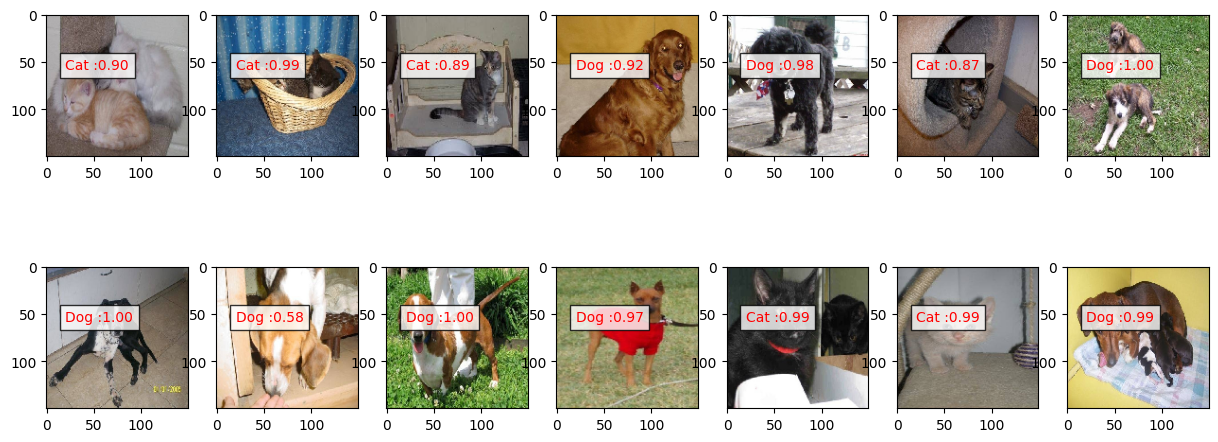

In [27]:
fig=plt.figure(figsize=(15, 6))
columns = 7
rows = 2
for root, dirs, files in os.walk(test_set_path):
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        img_path = f'{test_set_path}/{i+1}.jpg' 
        # Load and preprocess the image
        img1 = image.load_img(img_path, target_size=(150, 150))
        img = image.img_to_array(img1)
        img = img/255
        img = np.expand_dims(img, axis=0)
        prediction = classifier.predict(img, batch_size=None,steps=1) #gives all class prob.
        if(prediction[:,:]>0.5):
            value ='Dog :%1.2f'%(prediction[0,0])
            plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
        else:
            value ='Cat :%1.2f'%(1.0-prediction[0,0])
            plt.text(20, 58,value,color='red',fontsize=10,bbox=dict(facecolor='white',alpha=0.8))
        plt.imshow(img1)


In [28]:
# Model Accuracy
x1 = classifier.evaluate(train_set) 
x2 = classifier.evaluate(val_set)  
print('Training Accuracy  : %1.2f%%     Training loss  : %1.6f'%(x1[1]*100,x1[0]))
print('Validation Accuracy: %1.2f%%     Validation loss: %1.6f'%(x2[1]*100,x2[0]))

157/157 [==============================] - 30s 190ms/step - loss: 0.3020 - accuracy: 0.8710
Training Accuracy  : 91.43%     Training loss  : 0.213800
Validation Accuracy: 87.10%     Validation loss: 0.302017


### Get predictions of test dataset 

In [29]:
predictions =  []
for file in os.listdir(test_set_path):
    img_path = os.path.join(test_set_path, file)
    img = image.load_img(img_path, target_size=(150, 150))
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = classifier.predict(img)
    if prediction[0, 0] > 0.5:
        value = 'Dog'
    else:
        value = 'Cat'
    predictions.append({'filename': file, 'prediction': prediction[0, 0], 'class': value})
predictions = pd.DataFrame(predictions)
predictions.to_csv(f'{datetime.now().strftime("%Y%m%d_%H-%M-%S")}_predictions.csv', index=False)  

1/1 [==============================] - 0s 31ms/step
